<a href="https://colab.research.google.com/github/syedshubha/QNET25_Shubha/blob/main/Calculation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sympy import *
from sympy.physics.quantum import *
from itertools import permutations, product


symbols_list = symbols('A B C')

In [2]:
list(permutations(symbols_list, 2))

[(A, B), (A, C), (B, A), (B, C), (C, A), (C, B)]

In [3]:
list(product(symbols_list, repeat=2))

[(A, A), (A, B), (A, C), (B, A), (B, B), (B, C), (C, A), (C, B), (C, C)]

In [4]:
def cartesian(A, n):
  if n==1:
    return [[a] for a in A]
  else:
    result = []
    for a in A:
      for p in cartesian(A, n-1):
        result.append([a] + p)
    return result
cartesian(symbols_list, 2)

[[A, A], [A, B], [A, C], [B, A], [B, B], [B, C], [C, A], [C, B], [C, C]]

In [5]:
def tensoring(n,lst):
  ins = cartesian(lst, n)
  ch = []
  for i in ins:
    for j in range(n):
      if j == 0:
        p = i[j]
      else:
        p = TensorProduct(p,i[j])
    ch.append(p)
  return ch

In [6]:
# Channel
def evolve(rho,lst):
  DM = 0*rho
  for T in lst:
    DM = T*rho*(T.H) + DM
  return DM

In [7]:
AD = list(symbols('A0 A1',commutative=False))
PD = list(symbols('P0 P1 P2',commutative=False))

In [8]:
tensoring(2,AD)

[A0xA0, A0xA1, A1xA0, A1xA1]

In [9]:
def noise_channel(rho, p, q, n):
    # Amplitude damping operators
    E0_amp = Matrix([[1, 0], [0, sqrt(1 - p)]])
    E1_amp = Matrix([[0, sqrt(p)], [0, 0]])
    # Phase damping operators
    E0_phase = Matrix([[sqrt(q), 0], [0, 0]])
    E1_phase = Matrix([[0, 0], [0, sqrt(q)]])
    E2_phase = Matrix([[sqrt(1-q), 0], [0, sqrt(1-q)]])

    #Extending for two qubit systems
    AD = tensoring(n, [E0_amp, E1_amp])
    PD = tensoring(n, [E0_phase, E1_phase, E2_phase])

    # Evolve the channel
    rho_after_amp = evolve(rho, AD)
    rho_final1 = evolve(rho_after_amp, PD)

    rho_after_phase = evolve(rho, PD)
    rho_final2= evolve(rho_after_phase, AD)

    rho_final = (rho_final1 + rho_final2)/2
    return rho_final

In [10]:
rho = Matrix([[0.5,0,0,0.5],[0,0,0,0], [0,0,0,0], [0.5,0,0,0.5]])
p = symbols('p', real=True)
q = symbols('q', real=True)
noisy = noise_channel(rho, p, q,2)
noisy

Matrix([
[p**2*(1.0*sqrt(q)*sqrt(1 - q)*conjugate(sqrt(q))*conjugate(sqrt(1 - q)) + 0.5*q**2 + (0.5 - 0.5*q)*(1 - q))/2 + sqrt(q)*sqrt(1 - q)*(0.5*p**2 + 0.5)*conjugate(sqrt(q))*conjugate(sqrt(1 - q)) + 0.5*sqrt(q)*sqrt(1 - q)*conjugate(sqrt(q))*conjugate(sqrt(1 - q)) + q**2*(0.5*p**2 + 0.5)/2 + 0.25*q**2 + (0.5 - 0.5*q)*(1 - q)/2 + (1 - q)**2*(0.5*p**2 + 0.5)/2,                                                                                                                                                                                                                                                                                                                                                                                                                                                                  0,                                                                                                                                                                                       

In [11]:
temp = rho*noisy*rho

In [12]:
eigenvects, eigenvals = temp.diagonalize()
sqrt_eigenvals = diag(*[sqrt(val) for val in eigenvals.diagonal()])

# Compute the square root of the matrix
sqrt_A = eigenvects * sqrt_eigenvals * eigenvects.inv()

In [13]:
f_sympy=simplify((sqrt_A.trace())**2)

In [14]:
import numpy as np
import matplotlib.pyplot as plt

Text(0, 0.5, 'f(p, q)')

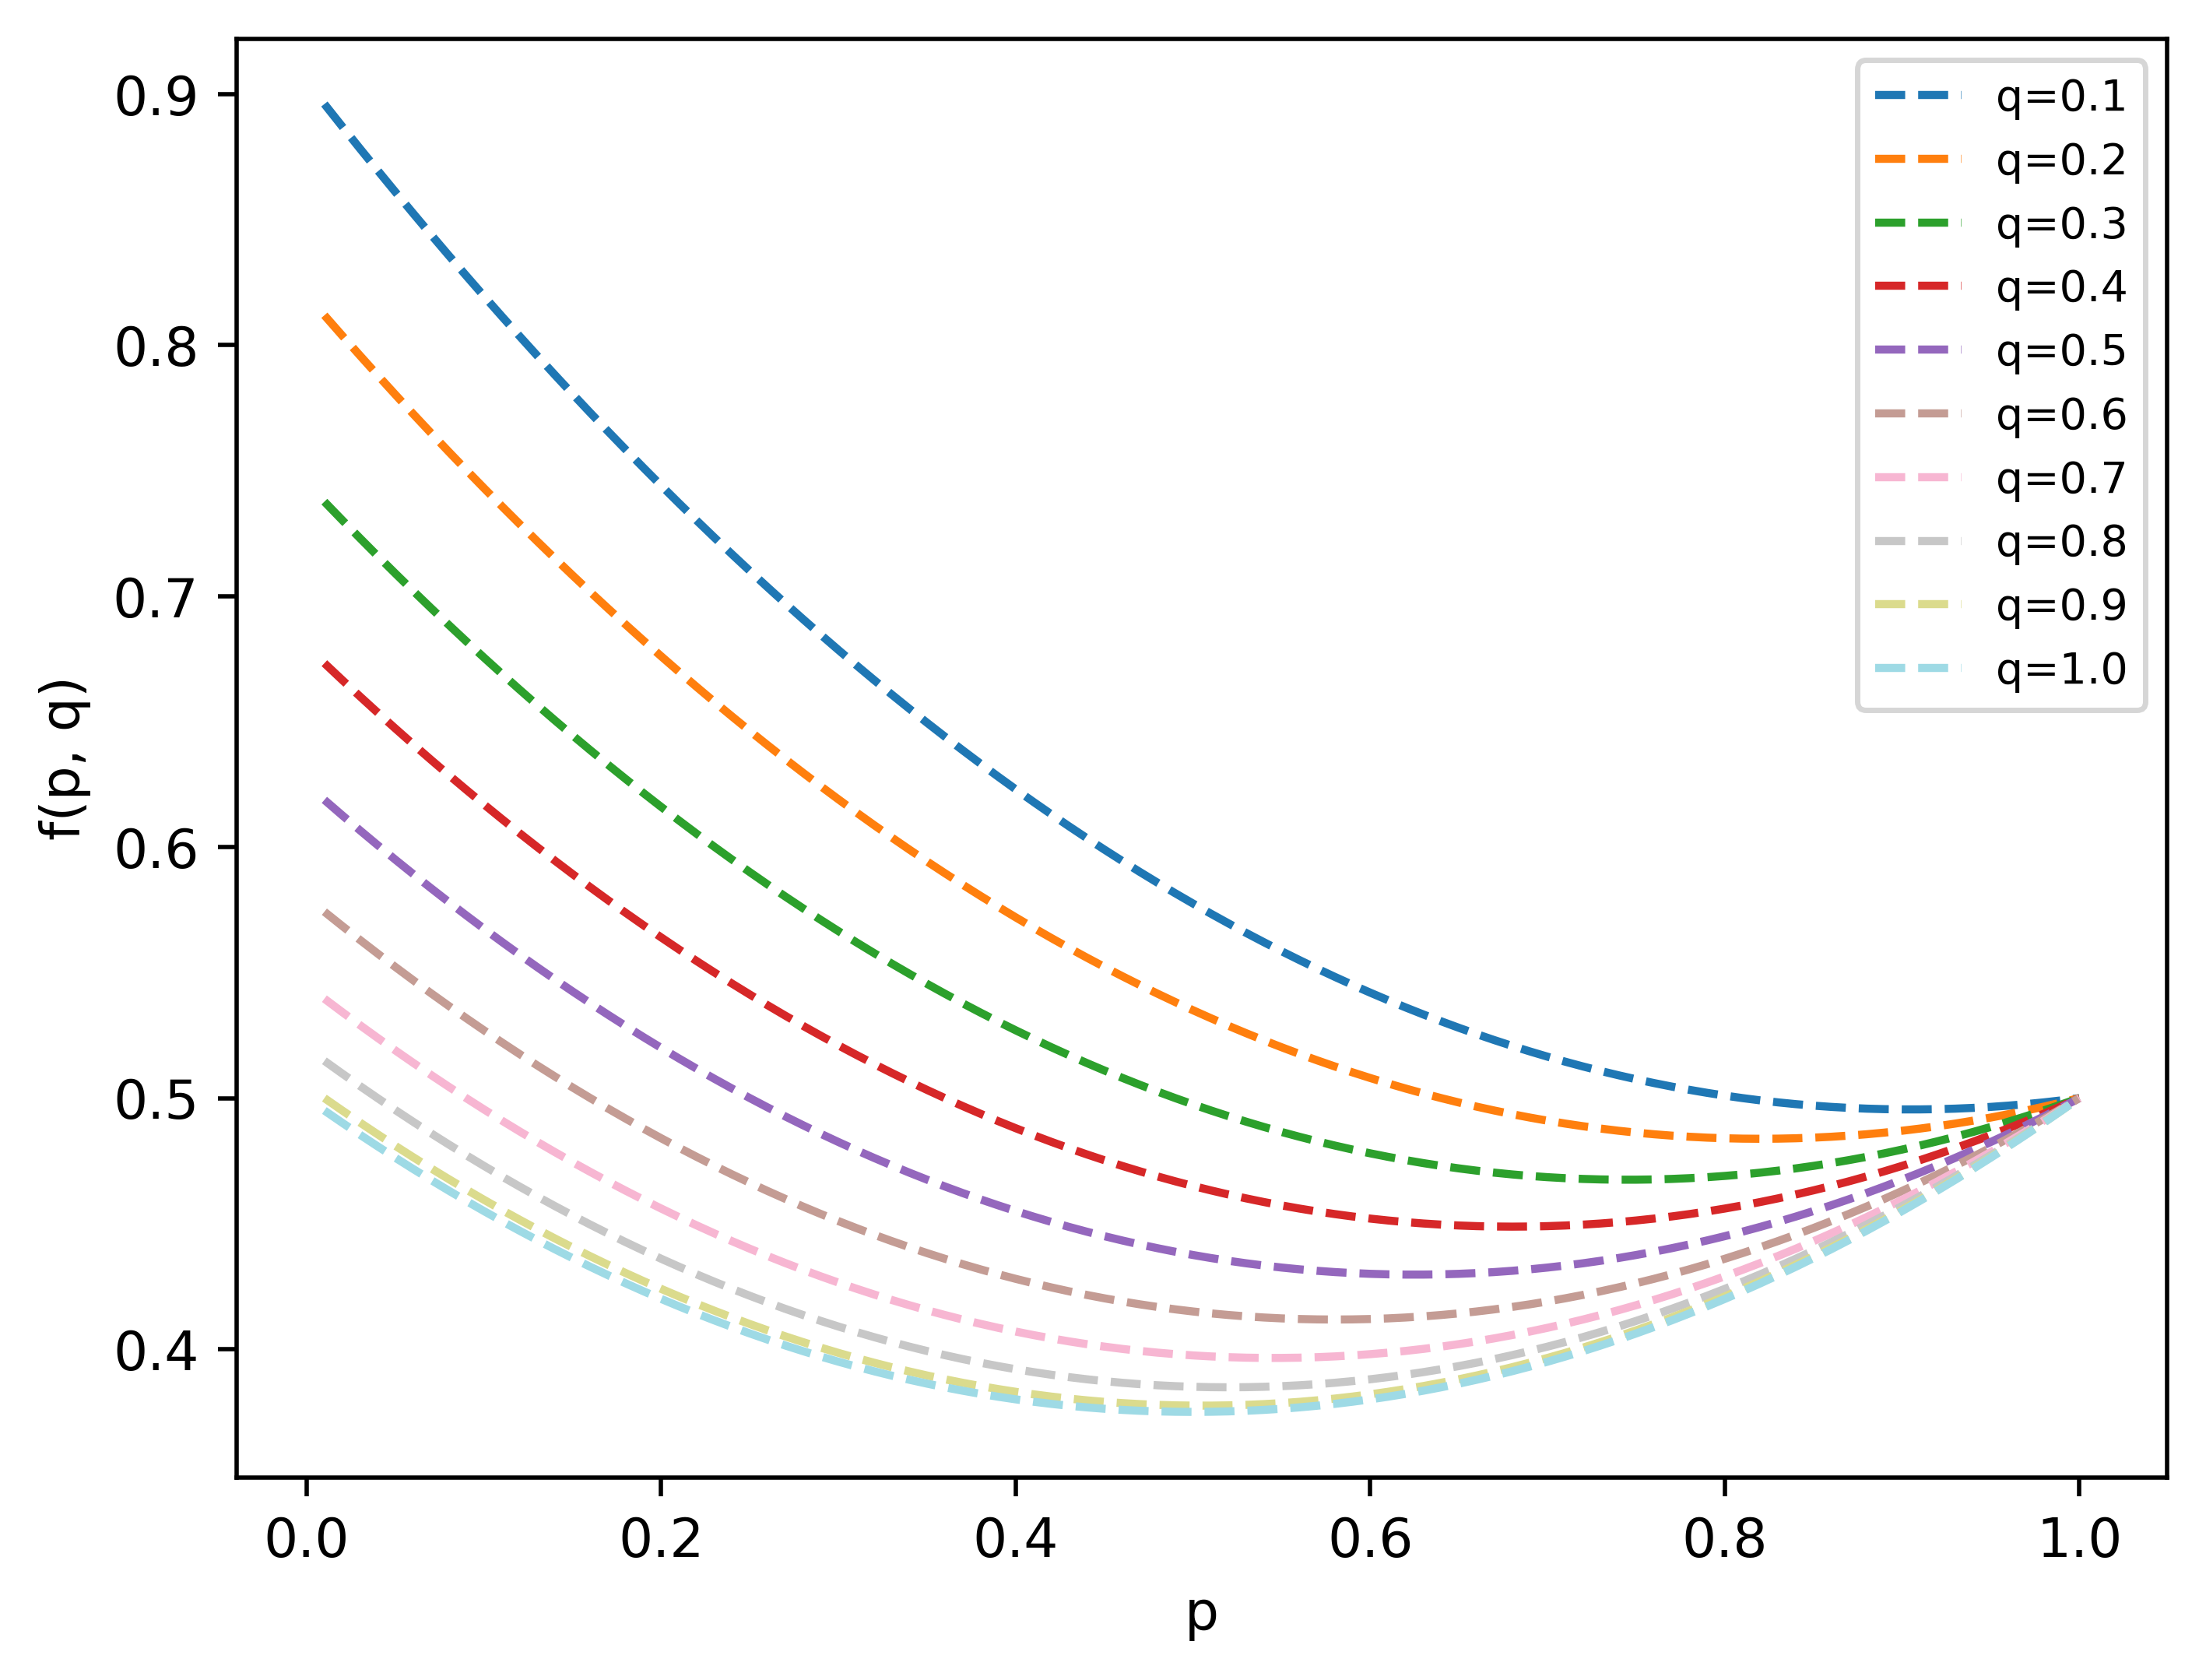

In [15]:
# Convert the symbolic function into a numpy-compatible function using lambdify
f_numpy = lambdify((p, q), f_sympy, 'numpy')

# Create a range of values for p and q
p_val = np.linspace(0.01, 1, 100)
q_val = np.linspace(0.1, 1, 10)

# Create a color palette for the lines
colors = plt.cm.tab20(np.linspace(0, 1, len(q_val)))

# Plot the function for different values of q
plt.figure(dpi=500)

for i in range(len(q_val)):
    # Evaluate the function for each q value at the p values
    y_val = f_numpy(p_val, q_val[i])

    # Plot the result, with different line style and color for each q
    plt.plot(p_val, y_val, label=f"q={round(q_val[i], 2)}", linestyle='--', color=colors[i])

# Add the legend and labels
plt.legend(loc='upper right', fontsize=8)
plt.xlabel('p')
plt.ylabel('f(p, q)')
